# CNN Project Part 3
#### • DOMAIN: Automobile
#### • CONTEXT: A brand research company wants to understand which cars or car manufacturers are popular in a certain area of the city or locality. Company has a team which takes pictures of the cars randomly through the day. Using this the company wants to set up an automation which can classify the make of the car once the picture has been given as an input.
#### • TASK: Help to build the image dataset to be used by the AI team to build an image classifier data. Import and display the images in python against their labels. Comment on the challenges faced during this task.

# (1) Import Python libraries

## (1.1) Enable GPU for this notebook

In [1]:
import tensorflow as tf
print("You are using TensorFlow version", tf.__version__)
if len(tf.config.list_physical_devices('GPU')) > 0:
  print("You have a GPU enabled.")
else:
  print("Enable a GPU before running this notebook.")

from tensorflow.keras.models import Sequential  # initial NN
from tensorflow.keras.layers import Dense, Dropout, InputLayer, BatchNormalization # construct each layer
from tensorflow.keras.layers import Conv2D # swipe across the image by 1
from tensorflow.keras.layers import MaxPool2D, GlobalMaxPool2D # swipe across by pool size
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input,decode_predictions

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
%matplotlib inline
from tqdm.notebook import trange, tqdm
import seaborn as sns
from google.colab.patches import cv2_imshow
from IPython.display import Image, display, Markdown, clear_output

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import svm, metrics
from sklearn.decomposition import PCA
from skimage import io
import math


You are using TensorFlow version 2.4.1
Enable a GPU before running this notebook.


## (1.2) Mount google drive that contains image dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## (2) Load Image dataset

## (2.1) Set the globval variables for project and image dta paths

In [3]:
image_path = '/content/drive/MyDrive/Colab Notebooks/DataFile/Cars Images/'
project_path = '/content/drive/MyDrive/Colab Notebooks/'

## (2.2) Read the dataframe conatining image file names and model details

In [4]:
cars_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cars_data_set.csv')
cars_df

,file_name,category,Make,model,segment,color,manufacture_year
0,00001.jpg,car,Audi,TT,sports,white,2011
1,00002.jpg,car,Acura,TL,sedan,black,2014
2,00003.jpg,car,Dodge,SLT,pickup truck,red,2006
3,00004.jpg,car,Hyundai,Sonata,sedan,red,2012
4,00005.jpg,car,Ford,F-350,pickup truck,white,2015
5,00006.jpg,car,Geo Metro,-,Convertible,red,1994
6,00007.jpg,car,Dodge,Journey,suv,blue,2017
7,00008.jpg,car,Dodge,Challenger,hybrid,red,2020
8,00009.jpg,car,Mitsubishi,Lancer,sedan,grey,2016
9,00010.jpg,car,Chevrolet,Traverse,suv,grey,2012


In [5]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   file_name         15 non-null     object
 1   category          15 non-null     object
 2   Make              15 non-null     object
 3   model             15 non-null     object
 4   segment           15 non-null     object
 5   color             15 non-null     object
 6   manufacture_year  15 non-null     int64 
dtypes: int64(1), object(6)
memory usage: 968.0+ bytes


#### Observations:
1. There are 15 images of cars along with the make, model , segment they belong to and their manufactured year.

### (2.2.1) Convert the `manuafacture_year` column from `int` to `str`

In [6]:
cars_df['manufacture_year'] = cars_df['manufacture_year'].astype('str')

In [7]:
cars_df['Description'] = cars_df['Make']+' '+cars_df['model'] + ' ' + cars_df['segment'] + ' ' + cars_df['color'] + ' ' + cars_df['manufacture_year']
cars_df

,file_name,category,Make,model,segment,color,manufacture_year,Description
0,00001.jpg,car,Audi,TT,sports,white,2011,Audi TT sports white 2011
1,00002.jpg,car,Acura,TL,sedan,black,2014,Acura TL sedan black 2014
2,00003.jpg,car,Dodge,SLT,pickup truck,red,2006,Dodge SLT pickup truck red 2006
3,00004.jpg,car,Hyundai,Sonata,sedan,red,2012,Hyundai Sonata sedan red 2012
4,00005.jpg,car,Ford,F-350,pickup truck,white,2015,Ford F-350 pickup truck white 2015
5,00006.jpg,car,Geo Metro,-,Convertible,red,1994,Geo Metro - Convertible red 1994
6,00007.jpg,car,Dodge,Journey,suv,blue,2017,Dodge Journey suv blue 2017
7,00008.jpg,car,Dodge,Challenger,hybrid,red,2020,Dodge Challenger hybrid red 2020
8,00009.jpg,car,Mitsubishi,Lancer,sedan,grey,2016,Mitsubishi Lancer sedan grey 2016
9,00010.jpg,car,Chevrolet,Traverse,suv,grey,2012,Chevrolet Traverse suv grey 2012


# (3) Visualize images

##(3.1) Set the resizing image size

In [8]:
img_sz = 224

## (3.2) Display all images with their labels from the dataframe.

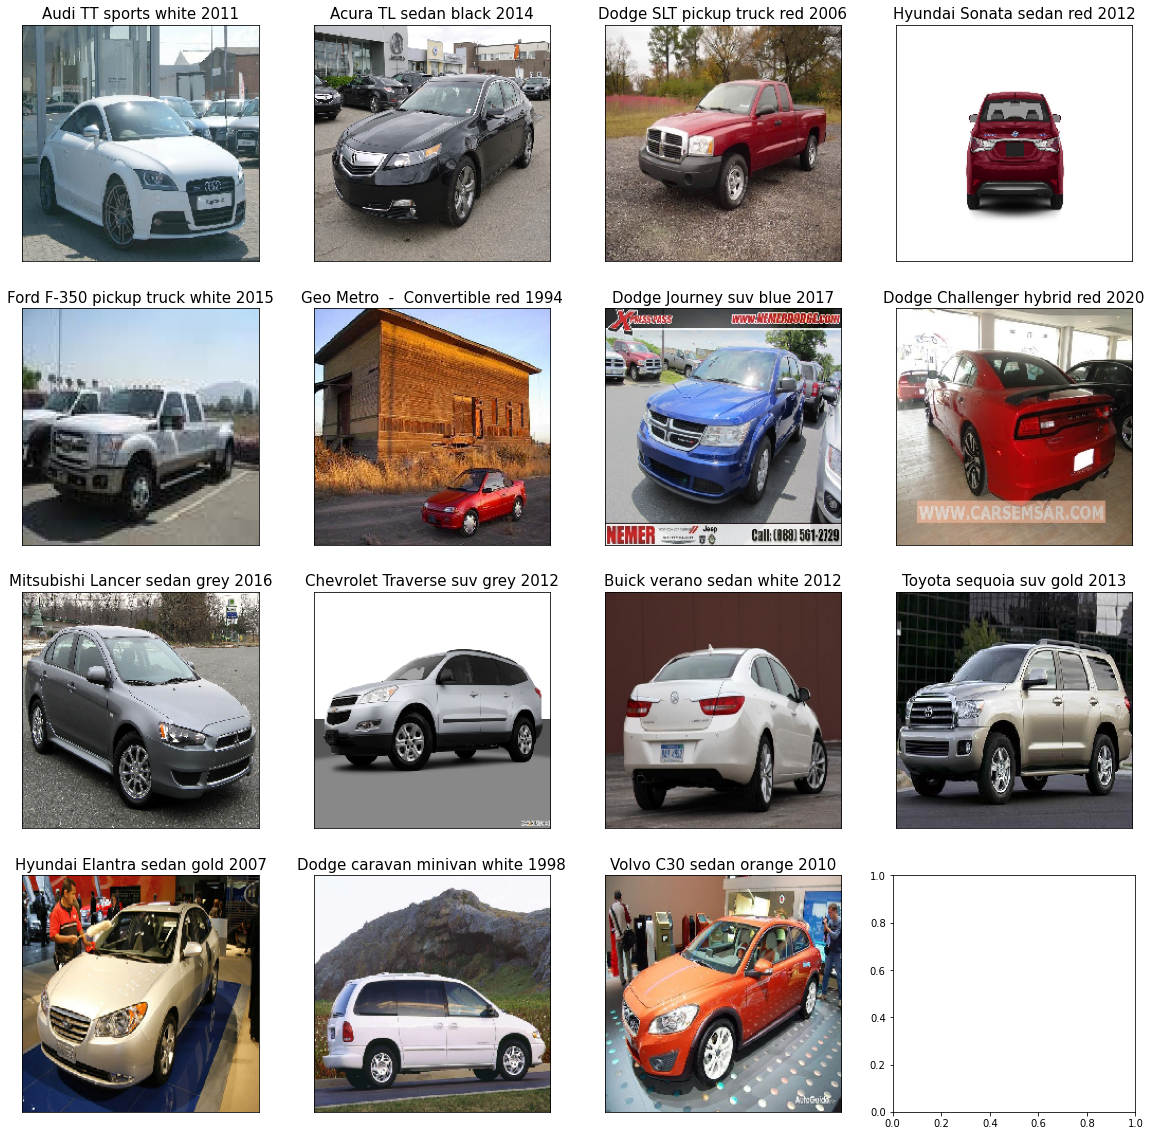

In [9]:
cols = 4
rows = int(math.ceil(len(cars_df)/cols))
fig, ax = plt.subplots(rows,cols,figsize=(20,20))
X = []
y = []
for index in range(0,len(cars_df)):

  img = cv2.imread(image_path+cars_df['file_name'][index])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(img_sz,img_sz),interpolation = cv2.INTER_NEAREST)
  X.append(img)
  y.append(cars_df['segment'][index])


  if index < cols:
    col = index
    row = int(index/4)
  else:
    col = index % 4
    row = int(index/4)

  ax[row][col].imshow(img)
  ax[row][col].set_title(f"{cars_df['Description'][index]}",fontsize=15)
  ax[row][col].tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False)
plt.show()
X = np.array(X)
y = np.array(y)


# (4) Use `Transfer learning` method to identify above cars.
#### Here we will use VGG16 to identify cars above

In [10]:
display(Markdown(f"#### Shape of image set is {X.shape} and {y.shape}"))

#### Shape of image set is (15, 224, 224, 3) and (15,)

## (4.1) Use the VGG16 `pre-trained` model to predict the type of cars

In [11]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')
print(model.summary())

553467904/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

#### Observations:
1. As we could see VGG16 has a total of 138M trainable parameters.
2. All these parameters are pre-trained using `imagenet`.
3. Also, the output layer has `1000` distint classes to choose from

## (4.2) Predict the type of car from the pictures and add it to the original dataframe

In [15]:
vgg_predict = []
for img in X:
  img = np.expand_dims(img,axis=0)
  img = preprocess_input(img)
  features = model.predict(img)
  p = decode_predictions(features)
  vgg_predict.append(p[0][0][1])

cars_df['VGG16-Label'] = vgg_predict

cars_df

,file_name,category,Make,model,segment,color,manufacture_year,Description,VGG16-Label
0,00001.jpg,car,Audi,TT,sports,white,2011,Audi TT sports white 2011,sports_car
1,00002.jpg,car,Acura,TL,sedan,black,2014,Acura TL sedan black 2014,minivan
2,00003.jpg,car,Dodge,SLT,pickup truck,red,2006,Dodge SLT pickup truck red 2006,pickup
3,00004.jpg,car,Hyundai,Sonata,sedan,red,2012,Hyundai Sonata sedan red 2012,vacuum
4,00005.jpg,car,Ford,F-350,pickup truck,white,2015,Ford F-350 pickup truck white 2015,limousine
5,00006.jpg,car,Geo Metro,-,Convertible,red,1994,Geo Metro - Convertible red 1994,mobile_home
6,00007.jpg,car,Dodge,Journey,suv,blue,2017,Dodge Journey suv blue 2017,minivan
7,00008.jpg,car,Dodge,Challenger,hybrid,red,2020,Dodge Challenger hybrid red 2020,sports_car
8,00009.jpg,car,Mitsubishi,Lancer,sedan,grey,2016,Mitsubishi Lancer sedan grey 2016,beach_wagon
9,00010.jpg,car,Chevrolet,Traverse,suv,grey,2012,Chevrolet Traverse suv grey 2012,minivan


## (4.3) Visualise the images with the true label and prediction

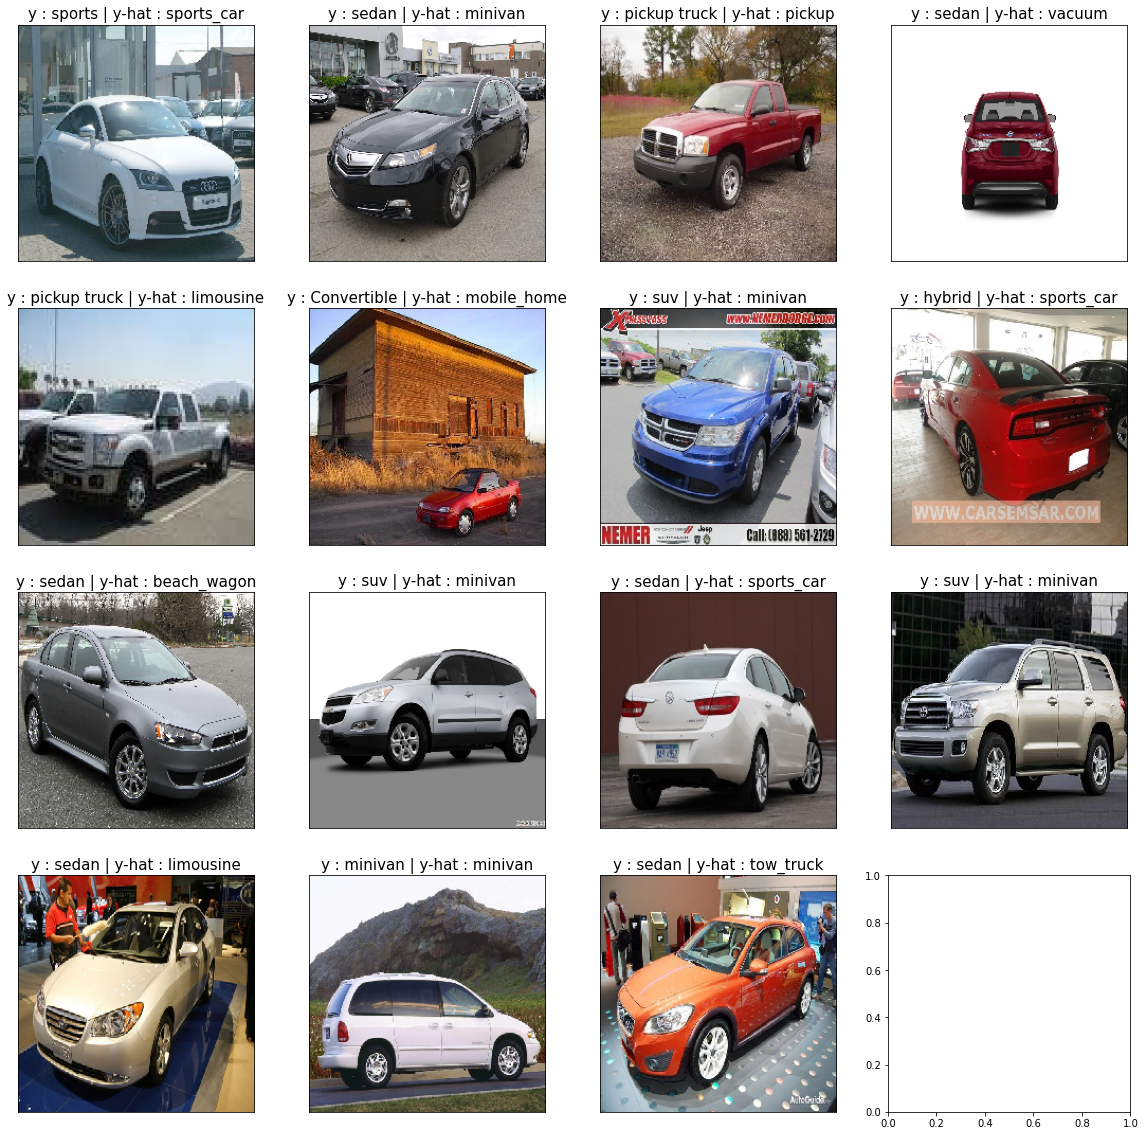

In [19]:
cols = 4
rows = int(math.ceil(len(cars_df)/cols))
fig, ax = plt.subplots(rows,cols,figsize=(20,20))

for index in range(0,len(cars_df)):

  img = cv2.imread(image_path+cars_df['file_name'][index])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(img_sz,img_sz),interpolation = cv2.INTER_NEAREST)

  if index < cols:
    col = index
    row = int(index/4)
  else:
    col = index % 4
    row = int(index/4)

  ax[row][col].imshow(img)
  ax[row][col].set_title(f"y : {cars_df['segment'][index]} | y-hat : {cars_df['VGG16-Label'][index]}",fontsize=15)
  ax[row][col].tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False)
plt.show()



#### Observations:
1. We could see that not all labels have been predicted correctly , especially the car `Geo Metro` which actually is a `convertible` but predicted as a `mobile_home`. This could be due to the reason that there is a home like structrure in the background and which dominates tha image of the car itself.

# (5) Conclusion:

## (5.1) Challenges faced:
1. Cars are in general identified by their logo in the front or rear and then by their physical appearence except a few luxuary lineup. If the images do not capture this details then it would be difficult to label them.
2. The background features most often also play a dominant role i.e if a car of interest has many other cars of different make or model in the background then the images can be potentially misidentified.
3. There are plenty of resources in the internet but to search them by picture is challenging without a proper label or logo on the car.


## (5.2) Solutions:
1. Used [Google Lens](https://lens.google.com/) capability in our android phone to search for cars in the image dataset and get their details and this cam eto our rescue
2. To avoid misclassification due to background images and noices, we had to crop the image of car.